# <center> Module 2 Project  - Northwind Database Hypothesis Testing

## <center>Matthew Sparr <br><br> <center><h8>Self-Paced Data Science Program

# <center> Introduction

First we will import all the necessary libraries.

In [124]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

Next we will connect to the database and grab all the table names.

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
                               ''').fetchall())
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

Now we will store each table from the database as Pandas Dataframe so that they are easy to work with and analyze. There was a technical error with the 'orders' table, so a CSV file of the table was generated using an outside program.

In [3]:
sql_comm = []
for i in range(0,len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)

employees = pd.read_sql_query(sql_comm[0], conn)
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)

suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
orders = pd.read_csv('Order.csv')

cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)

And here is a schema of the database.

<img src='Northwind_ERD.png'>

## Q1 -- Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

## <center>H<sub>0: The average quantity of product ordered is the same for orders with and without a discount.

## <center>H<sub>a: The average quantity of product ordered when a discount is given is higher or lower than for orders without a discount.

The above is our first question and both the null and alternative hypotheses. To test them will involve a two-tail test. This is because if the null hypothesis is rejected and there is a correlation between discount and order quantity, we could find that the discount amount either increases or decreases the quantity of product ordered. 

To test our hypotheses we will be using the table 'order_details' and will be looking only at the columns 'Quantity' and 'Discount'. Below we can see that there are no null or missing values in either column. Also, 'Quantity' ranges from 1 to 130 and 'Discount' ranges from 0 to 0.25.

In [4]:
order_details[['Quantity','Discount']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2155 non-null int64
Discount    2155 non-null float64
dtypes: float64(1), int64(1)
memory usage: 33.8 KB


In [5]:
order_details[['Quantity','Discount']].describe()

,Quantity,Discount
count,2155.000000,2155.000000
mean,23.812993,0.056167
std,19.022047,0.083450
min,1.000000,0.000000
25%,10.000000,0.000000
50%,20.000000,0.000000
75%,30.000000,0.100000
max,130.000000,0.250000


Now we will split our order details into two sets: discount and no discount. Running a t-test on the data below then gives us a small p-value of 1.14e-10 which is less than our alpha of 0.05.

In [6]:
no_disc = order_details[order_details['Discount'] == 0].copy()
disc = order_details[order_details['Discount'] > 0].copy()

p = stats.ttest_ind(no_disc.Quantity, disc.Quantity)[1]
p

1.1440924523215966e-10

Since the p-value for our t-test is so low, this allows us to reject the null-hypothesis and accept instead the alternative hypothesis. From this result we can reasonably argue that having a discount does indeed have an impact on the quantity of product ordered. 

For the second part of the question we will need to look at the different discount amounts and see where the size of the discount affects the quantity ordered the most. Let's start by looking at the unique values in 'Discount' below.

In [7]:
order_details.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Since the count of some discount values are so few compared to others, we will group those discount values together. Below we create 5 buckets of discount values and then add them each to an array so we can iterate through them. We will also be filtering out data where there is no discount given.

In [8]:
disc_5 = order_details['Quantity'][(order_details['Discount'] <= 0.05) & (order_details['Discount'] > 0)]
disc_10 = order_details['Quantity'][(order_details['Discount'] > 0.05) & (order_details['Discount'] <= 0.1)]
disc_15 = order_details['Quantity'][(order_details['Discount'] > 0.1) & (order_details['Discount'] <= 0.15)]
disc_20 = order_details['Quantity'][(order_details['Discount'] > 0.15) & (order_details['Discount'] <= 0.2)]
disc_25 = order_details['Quantity'][order_details['Discount'] > 0.2]
discounts = []
discounts.extend((['0.05 or less', disc_5], ['Between 0.05 and 0.10', disc_10],
                  ['Between 0.10 and 0.15', disc_15], ['Between 0.15 and 0.20', disc_20],
                  ['Greater than 0.20', disc_25]))

We can then view the size of each of these buckets and notice that they are all fairly similar in size.

In [9]:
for i in discounts:
    print(len(i[1]))

192
174
157
161
154


For this second part of the question, we will need a set of  null and alternative hypotheses.

## <center>H<sub>0: The average quantity of product ordered is the same for X and Y amount of discount.

## <center>H<sub>a: The average quantity of product ordered is different for X and Y amount of discount.

In the above hypotheses, X and Y represent two discount levels. Since we have 5 buckets of individual discount amounts, we will start by declaring the lowest one (0.05 or less) X and the next level up (between 0.05 and 0.10) Y and then running our T-test and checking the p-value. We will then repeat this up to the highest discount level giving us 4 seperate hypotheses to test.

In [10]:
for i in range(0, len(discounts)-1):
    X = discounts[i][1]
    y = discounts[i+1][1]
    p = stats.ttest_ind(X, y)[1]
    print(discounts[i][0] + " v.s. " + discounts[i+1][0] + " : " + str(p))

0.05 or less v.s. Between 0.05 and 0.10 : 0.39367155112980046
Between 0.05 and 0.10 v.s. Between 0.10 and 0.15 : 0.15837034442401487
Between 0.10 and 0.15 v.s. Between 0.15 and 0.20 : 0.5433964640207652
Between 0.15 and 0.20 v.s. Greater than 0.20 : 0.5801473824667989


None of the above p-values are below our alpha of 0.05. Therefore we fail to reject the null-hypothesis and cannot conclude that increasing the discount at any level will significantly affect the quantity of product ordered.

### Our findings show that having a discount on a product most likely will increase the quantity of product order but the actual amount of discount is statistically insignificant. 

## Q2 -- Are there certain products that are better to discount than others in order to increase the quantity ordered?

As a follow-up to our initial question, we will investigate whether or not the category of product intereacts with whether or not a discount is applied in regards to quantity of product ordered.

## <center>H<sub>0: There is no interaction between category of product and whether or not a discount is applied.

## <center>H<sub>a: There is some interaction between category of product and whether or not a discount is applied.

To test our hypothesis we will need data from more than one table so we will need to perform a couple merges. We will first join the 'products' table to the 'order-details' table as 'prod_ord_details'; and then merge that table with the 'categories' table.

In [11]:
prod_ord_details = pd.merge(products, 
                  order_details,
                  left_on='Id',
                  right_on='ProductId',
                  how='left')
prod_cat = pd.merge(prod_ord_details, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
prod_cat.head()

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount,Id,CategoryName,Description
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.20,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
3,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10348/1,10348,1,14.4,15,0.15,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
4,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10354/1,10354,1,14.4,12,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


Viewing the head of the merged table we can see lots of variables we don't need. We will create a new DataFrame with only the categories we need: 'Quantity', 'Discount', and 'CategoryName'.

In [12]:
q2_data = prod_cat[['Quantity', 'Discount', 'CategoryName']]
q2_data.head()

,Quantity,Discount,CategoryName
0,45,0.20,Beverages
1,18,0.00,Beverages
2,20,0.00,Beverages
3,15,0.15,Beverages
4,12,0.00,Beverages


Since we are concerned with the interaction between category and whether or not a discount is applied, we will need to modify our 'Discount' column to make it binary. We will do this by making all values of discount greater than zero equal to 1 and leaving no discount instances as 0.

In [22]:
q2_data['Discount'] = q2_data['Discount'].apply(lambda x: 1 if x > 0 else 0)

C:\Users\sparr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Since we want to test the impact of a variable ('Discount') on the dependent variable ('Quantity') for multiple groups ('CategoryName'), we will use analysis of variance or ANOVA to test our hypothesis. 

In [27]:
formula = 'Quantity ~ C(CategoryName)*C(Discount)'
lm = ols(formula, q2_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(CategoryName),1118.470015,7.0,0.449689,8.708672e-01
C(Discount),14729.606130,1.0,41.454988,1.484744e-10
C(CategoryName):C(Discount),3357.463105,7.0,1.349892,2.226259e-01
Residual,760020.189876,2139.0,NaN,NaN


From the above table we can see that the interaction of 'CategoryName' and 'Discount' has a p-value of ~0.223. Since this is less than our alpha of 0.05, we fail to reject the null hypothesis. From these results, it appears there is no significant difference in quantity of product ordered across the different combinations of category and whether or not a discount is applied. 

We can also view an interaction plot of our variables to show this lack of interaction.

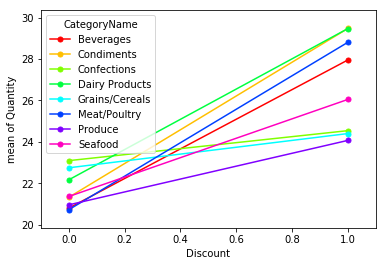

In [31]:
fig = interaction_plot(q2_data['Discount'],q2_data['CategoryName'],q2_data['Quantity'], ms=10)

We can see from the above graph that the lines for each of the category are mostly parallel with each other which implies little to no interaction with the other independent variable 'Discount'. The categories of 'Confections' and 'Grains/Cereals' do have slightly different slopes than the other categories but according to our ANOVA results, this difference is not significant.

### Our findings signify that there is not sufficient evidence that certain categories benefit more than others from having a discount applied versus not providing a discount. There may be some slight differences between certain categories but the differences overall are not statistically significant.

## Q3 -- Is there an optimal discount level based on the price of the product?

For this question we are wondering whether or not there is an interaction between 'Discount' and 'UnitPrice'. From this we can learn whether a certain discount level can lead to a higher 'Quantity' of product ordered depending on the product's price.

## <center>H<sub>0: There is no interaction between the discount level and unit price in regards to quantity.

## <center>H<sub>a: There is some interaction between discount level and unit price in regards to quantity.

To answer this question we will first need to create a relevant data table. Since we are only concerned with 'UnitPrice', 'Discount' and 'Quantity', we can simply grab those from the 'order_details' table.

In [ ]:
q3_data = order_details[['UnitPrice', 'Discount', 'Quantity']].copy()

From the first question, we know that there are a couple 'Discount' values with few instances.

In [70]:
q3_data['Discount'].value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

Since the values with low value counts are all close to 0.05, we will modify those few 'Discount' levels and set them equal to 0.05.

In [71]:
q3_data['Discount'] = q3_data['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)

In [72]:
q3_data['Discount'].value_counts()

0.00    1317
0.05     193
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

Since we are looking to analyze the interaction between a categorical variable 'Discount' and a continuous variable 'UnitPrice' we will use analysis of covariance or ANCOVA to answer our hypothesis.

In [75]:
formula = 'Quantity ~ C(Discount)*UnitPrice'
lm = ols(formula, q3_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7813
Date:                Tue, 27 Nov 2018   Prob (F-statistic):              0.634
Time:                        15:56:42   Log-Likelihood:                -3727.2
No. Observations:                 838   AIC:                             7474.
Df Residuals:                     828   BIC:                             7522.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        27.3221      1.879     14.538      0.000      23.633      31.011
C(Discount)[T.0.1]               -0.8050      2.779     -0.290      0.772      -6.260       4.650
C(Discount)[T.0.15]               0.7361      3.458      0.213      0.831      -6.051       7.523
C(Discount)[T.0.2]               -2.4255      2.932     -0.827      0.408      -8.180       3.329
C(Discount)[T.0.25]              -1.1356      3.010     -0.377      0.706      -7.044       4.772
UnitPrice                        -0.0130      0.037     -0.352      0.725      -0.085       0.059
C(Discount)[T.0.1]:UnitPrice     -0.0379      0.064     -0.596      0.551      -0.163       0.087
C(Discount)[T.0.15]:UnitPrice     0.0271      0.110      0.246      0.806      -0.189       0.243
C(Discount)[T.0.2]:UnitPrice      0.1035      0.075      1.375      0.169      -0.044       0.251
C(Discount)[T.0.25]:UnitPrice     0.0858      0.069      1.241      0.215      -0.050       0.222
==============================================================================
Omnibus:                      266.827   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.669
Skew:                           1.598   Prob(JB):                    3.31e-167
Kurtosis:                       6.426   Cond. No.                         279.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above results we can see that the p-values for each of our interaction terms are all greater than our alpha value. We thus fail to reject our null hypothesis. This suggests that there is no significant interaction between 'Discount' level and 'UnitPrice'. 

The low R-squared value of 0.008 for the model also shows how poor of a fit a regression using only 'Discount' level and 'UnitPrice' are in predicting the 'Quantity' of product ordered.

### Our findings suggest there is no optimal discount level given the price of a product. 

## Q4 -- Do some employees perform better in average order price than others?

## <center>H<sub>0: The average amount spent per order is the same across all employees.

## <center>H<sub>0: The average amount spent per order varies amongst employees.

In [81]:
orders.EmployeeId.value_counts()

4    156
3    127
1    123
8    104
2     96
7     72
6     67
9     43
5     42
Name: EmployeeId, dtype: int64

In [82]:
q4_data = pd.merge(orders, 
                  order_details,
                  left_on='Id',
                  right_on='OrderId',
                  how='left')
q4_data.head()

,Id_x,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id_y,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/11,10248,11,14.0,12,0.0
1,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/42,10248,42,9.8,10,0.0
2,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,10248/72,10248,72,34.8,5,0.0
3,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/14,10249,14,18.6,9,0.0
4,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,10249/51,10249,51,42.4,40,0.0


In [90]:
q4_data['Sale'] = q4_data['Quantity']*(q4_data['UnitPrice']*(1 - q4_data['Discount']))

In [91]:
q4_data.Sale.head()

0     168.0
1      98.0
2     174.0
3     167.4
4    1696.0
Name: Sale, dtype: float64

<BarContainer object of 2155 artists>

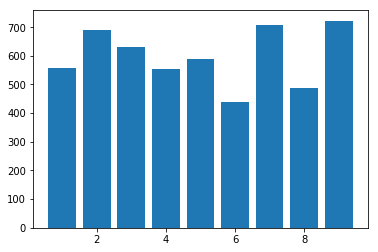

In [103]:
X = q4_data['EmployeeId']
y = []
for i in q4_data['EmployeeId']:
    y.append(q4_data['Sale'][q4_data['EmployeeId'] == i].mean())
plt.bar(X,y)

In [122]:
formula = 'Sale ~ C(EmployeeId)'
lm = ols(formula, q4_data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(EmployeeId),8.0,1.472611e+07,1.840763e+06,1.966553,0.046929
Residual,2146.0,2.008732e+09,9.360354e+05,NaN,NaN


In [125]:
mc = MultiComparison(q5_data['Sale'], q5_data['EmployeeId'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
  1      2     134.1944 -117.9953 386.3841 False 
  1      3     74.9821  -157.9727 307.9368 False 
  1      4     -2.3316  -220.6011 215.9379 False 
  1      5     31.1346  -290.2426 352.5118 False 
  1      6    -116.8745 -399.4868 165.7378 False 
  1      7     150.9404 -127.3188 429.1996 False 
  1      8     -68.9018 -315.6068 177.8032 False 
  1      9     165.6717 -166.7309 498.0742 False 
  2      3     -59.2123 -315.2499 196.8252 False 
  2      4     -136.526 -379.2787 106.2267 False 
  2      5    -103.0598 -441.5426 235.423  False 
  2      6    -251.0689 -552.9911 50.8533  False 
  2      7      16.746  -281.1054 314.5975 False 
  2      8    -203.0962  -471.705 65.5126  False 
  2      9     31.4773  -317.4909 380.4454 False 
  3      4     -77.3137 -300.0179 145.3906 False 
  3      5     -43.8475  -368.253 280.558  False 

In [120]:
q5_data = pd.merge(orders, 
                  order_details,
                  left_on='Id',
                  right_on='OrderId',
                  how='left')
q5_data = pd.merge(q5_data, 
                  products,
                  left_on='ProductId',
                  right_on='Id',
                  how='left')
q5_data = pd.merge(q5_data, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
q5_data = q5_data.rename(index=str, columns={"UnitPrice_x": "UnitPrice"})
q5_data['Sale'] = q5_data['Quantity']*(q5_data['UnitPrice']*(1 - q5_data['Discount']))
q5_data = q5_data[['EmployeeId', 'CategoryName', 'Sale']]
q5_data.head()

,EmployeeId,CategoryName,Sale
0,5,Dairy Products,168.0
1,5,Grains/Cereals,98.0
2,5,Dairy Products,174.0
3,6,Produce,167.4
4,6,Produce,1696.0


In [127]:
formula = 'Sale ~ C(EmployeeId)*C(CategoryName)'
lm = ols(formula, q5_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(EmployeeId),1.554216e+07,8.0,2.089979,3.365327e-02
C(CategoryName),4.721500e+07,7.0,7.256091,1.293990e-08
C(EmployeeId):C(CategoryName),2.523537e+07,56.0,0.484777,9.995606e-01
Residual,1.936282e+09,2083.0,NaN,NaN


In [141]:
for i in q5_data['CategoryName'].unique():
    mc = MultiComparison(q5_data['Sale'][q5_data['CategoryName'] == i], q5_data['EmployeeId'][q5_data['CategoryName'] == i])
    result = mc.tukeyhsd()
    print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
  1      2      107.26  -339.3278 553.8478 False 
  1      3     79.5422  -322.5645 481.6489 False 
  1      4     67.0929  -328.7055 462.8913 False 
  1      5     153.4656 -315.7281 622.6593 False 
  1      6    -117.3012 -552.6946 318.0921 False 
  1      7     336.828  -132.3657 806.0218 False 
  1      8     66.4318  -388.5307 521.3942 False 
  1      9     289.8453  -216.036 795.7266 False 
  2      3     -27.7179 -495.6441 440.2083 False 
  2      4     -40.1671 -502.6836 422.3493 False 
  2      5     46.2056  -480.4896 572.9008 False 
  2      6    -224.5613 -721.3837 272.2611 False 
  2      7     229.568  -297.1272 756.2633 False 
  2      8     -40.8283 -554.8866 473.2301 False 
  2      9     182.5853 -377.0405 742.2111 False 
  3      4     -12.4493 -432.1761 407.2776 False 
  3      5     73.9235  -415.6243 563.4712 False 

In [122]:
for i in q2_data['CategoryName'].unique():
    formula = 'Quantity ~ C(Discount)'
    lm = ols(formula, q2_data[q2_data['CategoryName'] == i]).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(i)
    print(table)
    print('------------------------------------------------------')

Beverages
                    sum_sq     df        F    PR(>F)
C(Discount)    7080.094979    5.0  3.97345  0.001577
Residual     141835.330764  398.0      NaN       NaN
------------------------------------------------------
Condiments
                   sum_sq     df         F    PR(>F)
C(Discount)   6693.336980    5.0  3.638131  0.003538
Residual     77270.496353  210.0       NaN       NaN
------------------------------------------------------
Produce
                   sum_sq     df         F    PR(>F)
C(Discount)    589.240857    5.0  0.336231  0.890214
Residual     45564.729731  130.0       NaN       NaN
------------------------------------------------------
Meat/Poultry
                   sum_sq     df         F    PR(>F)
C(Discount)   7150.327552    5.0  3.065112  0.011285
Residual     77915.903662  167.0       NaN       NaN
------------------------------------------------------
Seafood
                    sum_sq     df         F    PR(>F)
C(Discount)    6080.291962    5.0  3.434

A few of the above tests show a p-value of less than our alpha of 0.05. However, because we ran multiple additional tests, we should use a Bonferroni correction.

In [123]:
k = len(q2_data['CategoryName'].unique())
alpha = 0.05
bon_alpha = alpha/k
bon_alpha

0.00625

Since we have 8 cateogories, we divide our alpha of 0.05 by 8 to get a new relevant alpha of 0.00625. Now comparing this to our results above, we can see that the categories of 'Beverages', 'Condiments', and 'Seafood' all have significantly different means of 'Quantity' across the different 'Discount' levels. 

We can observe the interaction between these categories and 'Discount' in an interaction plot.

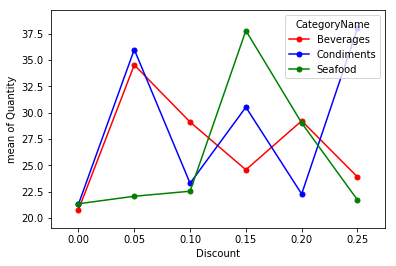

In [139]:
from statsmodels.graphics.factorplots import interaction_plot
q2_data_a = q2_data[(q2_data['CategoryName'] == 'Beverages') | (q2_data['CategoryName'] == 'Condiments') 
                    | (q2_data['CategoryName'] == 'Seafood')]
fig = interaction_plot(q2_data_a['Discount'],q2_data_a['CategoryName'],q2_data_a['Quantity'],
                       colors = ['red', 'blue', 'green'], ms=10)

The above plot shows how the mean 'Quantity' changes in relation to the 'Discount' for each of the three categories. Interestingly, the highest mean for each category occurs at a different 'Discount' level. For 'Beverages', 0.05; for 'Condiments', 0.15; and for 'Seafood', 0.25.

To dig a little deeper, we can run a multiple comparison of mean using Tukey HSD to see where there's a significant difference between two 'Discount' levels. To do this, we will also need to calculate the appropriate family-wise error rate. Since we have 6 'Discount' levels (0.0, 0.05, 0.10, 0.15, 0.20, and 0.25) and will choose 2 for each comparison, we will have a total of 15 combinations. 

In [148]:
m = [q2_data[q2_data['CategoryName'] == 'Beverages'], q2_data[q2_data['CategoryName'] == 'Condiments'],
    q2_data[q2_data['CategoryName'] == 'Seafood']]
results = []
for i in m:
    mc = multi.MultiComparison(i['Quantity'], i['Discount'])
    combinations = 15
    fwer = 1 - (1 - alpha)**combinations
    r = mc.tukeyhsd(fwer)
    results.append([i, r])
    print(r)

Multiple Comparison of Means - Tukey HSD,FWER=0.54
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.05  13.7417   7.1835  20.2999  True 
 0.0    0.1    8.3233   1.6475   14.999  True 
 0.0    0.15   3.7866  -1.8883   9.4615 False 
 0.0    0.2    8.434    2.9528  13.9152  True 
 0.0    0.25   3.1095  -2.8668   9.0858 False 
 0.05   0.1   -5.4185  -14.3265  3.4896 False 
 0.05   0.15  -9.9551   -18.14  -1.7703  True 
 0.05   0.2   -5.3077  -13.3595  2.7441 False 
 0.05   0.25  -10.6322 -19.0289 -2.2356  True 
 0.1    0.15  -4.5367  -12.816   3.7427 False 
 0.1    0.2    0.1108   -8.037   8.2586 False 
 0.1    0.25  -5.2138  -13.7025  3.275  False 
 0.15   0.2    4.6474  -2.7028  11.9977 False 
 0.15   0.25  -0.6771  -8.4036   7.0494 False 
 0.2    0.25  -5.3245  -12.9099  2.2608 False 
----------------------------------------------
Multiple Comparison of Means - Tukey HSD,FWER=0.54
group1 group2 meandiff  lower    upper  reject
-----

From these results we can see that each category has several comparisons that have a statistically significant difference in mean of 'Quantity' of product sold in an order. 

For 'Beverages', going from no discount to either a 0.05, 0.10, or 0.20 discount all show a moderate increase in 'Quantity' with the highest increase being with a 'Discount' of 0.05. We also see that, strangely, a 'Discount' of 0.20 or 0.25 both have a lower average 'Quantity' when compared with a 'Discount' of 0.05.

For 'Condiments'

0.05   0.15  -9.9551   -18.14  -1.7703  True 
 0.05   0.2   -5.3077  -13.3595  2.7441 False 
 0.05   0.25  -10.6322 -19.0289 -2.2356  True 

In [81]:
d05 = q2_data[q2_data['Discount'] == 0.05].copy()
d10 = q2_data[q2_data['Discount'] == 0.10].copy()
d15 = q2_data[q2_data['Discount'] == 0.15].copy()
d20 = q2_data[q2_data['Discount'] == 0.20].copy()
d25 = q2_data[q2_data['Discount'] == 0.25].copy()


mc = multi.MultiComparison(d05['Quantity'], d05['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d10['Quantity'], d10['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d15['Quantity'], d15['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d20['Quantity'], d20['CategoryName'])
print(mc.tukeyhsd())

mc = multi.MultiComparison(d25['Quantity'], d25['CategoryName'])
print(mc.tukeyhsd())



      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
    group1         group2     meandiff  lower    upper  reject
--------------------------------------------------------------
  Beverages      Condiments    1.4615  -18.6254 21.5485 False 
  Beverages     Confections   -8.7965  -26.7566  9.1635 False 
  Beverages    Dairy Products -6.2458  -23.1773 10.6858 False 
  Beverages    Grains/Cereals -14.094  -34.8022  6.6141 False 
  Beverages     Meat/Poultry  -16.7149 -37.7799   4.35  False 
  Beverages       Produce     -6.9551  -30.5247 16.6145 False 
  Beverages       Seafood     -12.467  -30.8607  5.9267 False 
  Condiments    Confections   -10.2581 -29.6279  9.1118 False 
  Condiments   Dairy Products -7.7073  -26.1276 10.7129 False 
  Condiments   Grains/Cereals -15.5556 -37.4977  6.3865 False 
  Condiments    Meat/Poultry  -18.1765 -40.4556  4.1027 False 
  Condiments      Produce     -8.4167  -33.0775 16.2441 False 
  Condiments      Seafood     -13.9286 -33.7012  5.844 

In [65]:
cats = q2_data['CategoryName'].unique()
disc = q2_data['Discount'].unique()
for i in disc:
    for j in cats:
        c = 0
        while c < len(cats):
            print(str(i) + " " + str(j) + " " + str(cats[c]))
            X = q2_data['Quantity'][(q2_data['Discount'] == i) & (q2_data['CategoryName'] == j)]
            y = q2_data['Quantity'][(q2_data['Discount'] == i) & (q2_data['CategoryName'] == cats[c])]
            p = stats.ttest_ind(X, y)[1]
            print(p)
            c += 1

0.2 Beverages Beverages
1.0
0.2 Beverages Condiments
0.26344649959191296
0.2 Beverages Produce
0.3818807213817351
0.2 Beverages Meat/Poultry
0.23054143194900173
0.2 Beverages Seafood
0.9659235744330277
0.2 Beverages Dairy Products
0.639422003629611
0.2 Beverages Confections
0.08973039879170229
0.2 Beverages Grains/Cereals
0.8033409004824805
0.2 Condiments Beverages
0.26344649959191296
0.2 Condiments Condiments
1.0
0.2 Condiments Produce
0.9020378960918317
0.2 Condiments Meat/Poultry
0.8376414929730767
0.2 Condiments Seafood
0.2109664237141852
0.2 Condiments Dairy Products
0.15789268732887937
0.2 Condiments Confections
0.6243315842599158
0.2 Condiments Grains/Cereals
0.47346408444082566
0.2 Produce Beverages
0.3818807213817351
0.2 Produce Condiments
0.9020378960918317
0.2 Produce Produce
1.0
0.2 Produce Meat/Poultry
0.9662678798829597
0.2 Produce Seafood
0.3081781004421114
0.2 Produce Dairy Products
0.2793523306792966
0.2 Produce Confections
0.8096489033271768
0.2 Produce Grains/Cereals

1.0
0.25 Condiments Produce
0.32286948903926094
0.25 Condiments Meat/Poultry
0.7598634891547071
0.25 Condiments Seafood
0.04973847841459459
0.25 Condiments Dairy Products
0.657777349237066
0.25 Condiments Confections
0.30454799432574214
0.25 Condiments Grains/Cereals
0.1346256444450837
0.25 Produce Beverages
0.7971437289840291
0.25 Produce Condiments
0.32286948903926094
0.25 Produce Produce
1.0
0.25 Produce Meat/Poultry
0.2252226895781466
0.25 Produce Seafood
0.544946191912381
0.25 Produce Dairy Products
0.3637306658087224
0.25 Produce Confections
0.647065009437843
0.25 Produce Grains/Cereals
0.48910009861447445
0.25 Meat/Poultry Beverages
0.04503675290762132
0.25 Meat/Poultry Condiments
0.7598634891547071
0.25 Meat/Poultry Produce
0.2252226895781466
0.25 Meat/Poultry Meat/Poultry
1.0
0.25 Meat/Poultry Seafood
0.017128149882226704
0.25 Meat/Poultry Dairy Products
0.8299251863159581
0.25 Meat/Poultry Confections
0.3136526962593397
0.25 Meat/Poultry Grains/Cereals
0.04796909632945028
0.2

In [16]:
results = []
for i in q2_data['CategoryName'].unique():
    i_data = q2_data[q2_data['CategoryName'] == i]
    formula = 'Quantity ~ ' + 
    lm = ols(formula, j_data).fit()
    table = sm.stats.anova_lm(lm, typ=1)
    results.append([str(i) + " + " + str(j), table['F'].iloc[0], table['PR(>F)'].iloc[0]])

PatsyError: expected a noun, but instead the expression ended
    Quantity ~
             ^

Since we are doing some post-hoc testing, we need to use a Bonferroni correction to avoid p-hacking. The adjusted alpha is calculated below.

In [ ]:
n = len(q2_data['CategoryName'].unique())
alpha = 0.05
bon_alpha = alpha/n
bon_alpha

With our new adjusted alpha, we can now view the results where the p-value is less than our 'bon_alpha' value.

In [ ]:
for i in results:
    if i[2] < bon_alpha:
        print(i)

We can see that 3 of the categories produced results with significant probabilities. Out of these, 'Beverages' and 'Dairy Products' both have high F-values of ~13.74 and ~13.56 respectively, while 'Condiments' has a lesser F-value of ~9.1. From these results, it would suggest that for products in the categories of 'Beverages', 'Dairy Products', and 'Condiments', providing a discount will almost always increase the quantity of product sold. Furthermore, that increase in product sold will be highest in 'Beverages' and 'Dairy Products'.

### Our findings show that having a discount on a product most likely will increase the quantity of product order but the actual amount of discount is statistically insignificant. 

In [ ]:
formula = 'Quantity ~ C(CategoryName)*C(Discount_bin)'
lm = ols(formula, q2_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

First let's do what we did in the first question and place the 'Discount' values into buckets.

In [ ]:
q2_data['Discount'].value_counts()

In [ ]:
q2_data['Discount'] = q2_data['Discount'].apply(lambda x: 0.05 if (x > 0 and x < 0.10) else x)
q2_data['Discount'].value_counts()

In [ ]:
formula = 'Quantity ~ C(CategoryName)*C(Discount)'
lm = ols(formula, q2_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

In [ ]:
from statsmodels.graphics.factorplots import interaction_plot
fig = interaction_plot(q2_data.Discount, q2_data.CategoryName, q2_data.Quantity,
             colors=['red','blue','green','yellow','purple','orange','pink', 'black'], ms=10)

In [ ]:
formula = 'Quantity ~ C(Discount)*C(CategoryName)'
lm = ols(formula, q2_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

In [ ]:
formula = 'Quantity ~ C(CategoryName) + C(Discount)'
lm = ols(formula, q2_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

In [ ]:
q2_data = q2_data.join(pd.get_dummies(q2_data['CategoryName']))
q2_data.columns = [c.replace(' ', '_') for c in q2_data.columns]
q2_data.columns = [c.replace('/', '_') for c in q2_data.columns]
q2_data.head()

In [ ]:
for i in q2_data['CategoryName'].unique():
    data = q2_data[q2_data['CategoryName'] == i]
    formula = 'Quantity ~ C(Disc)'
    lm = ols(formula, data).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(i)
    print(table)

In [ ]:
X = order_details['Quantity'][(order_details['Discount'] < 0.15) & (order_details['Discount'] > 0)]
y = order_details['Quantity'][(order_details['Discount'] > 0.15)]
p = stats.ttest_ind(X, y)[1]
p

In [ ]:
orders.ShipCountry.value_counts()

In [ ]:
orders.head()

In [ ]:
order_countries = orders[['Id','ShipCountry']]

In [ ]:
order_disc_quan = order_details[['OrderId','Discount','Quantity']]

In [ ]:
df = pd.merge(order_countries, 
                  order_disc_quan,
                  left_on='Id',
                  right_on='OrderId',
                  how='left')

In [ ]:
df.head()

In [ ]:
df = df.join(pd.get_dummies(df.ShipCountry))


In [ ]:
df.head()

In [ ]:
columns = "+Discount*".join(df.drop(['Quantity', 'OrderId', 'Id', 'Discount'], axis=1).columns)
f = 'Quantity~' + columns
round(ols(formula=f, data=df).fit().pvalues,5)

In [ ]:
order_details.Discount.hist()

In [ ]:
disc_05 = order_details[['Quantity','Discount']][(order_details.Discount<0.05) & (order_details.Discount>0)]
disc_15 = order_details[['Quantity','Discount']][(order_details.Discount<0.15) & (order_details.Discount > 0.05)]
disc_25 = order_details[['Quantity','Discount']][order_details.Discount>0.15]
print("Less than 5% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_05).fit().pvalues[1],5)))
print("Between 5% and 15% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_15).fit().pvalues[1],5)))
print("Between 15% and 25% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_25).fit().pvalues[1],5)))

In [ ]:
d = 0
for i in sorted(order_details.Discount.unique()):
    d = order_details[['Quantity', 'Discount']][order_details.Discount==i].copy()
    print(str(i)+ " : " + str(ols(formula='Quantity ~ Discount', data=d).fit().pvalues[1]))

In [ ]:
disc_5 = order_details['Quantity'][order_details['Discount'] <= 0.05]
disc_10 = order_details['Quantity'][(order_details['Discount'] > 0.05) & (order_details['Discount'] <= 0.1)]
disc_15 = order_details['Quantity'][(order_details['Discount'] > 0.1) & (order_details['Discount'] <= 0.15)]
disc_20 = order_details['Quantity'][(order_details['Discount'] > 0.15) & (order_details['Discount'] <= 0.2)]
disc_25 = order_details['Quantity'][order_details['Discount'] > 0.2]
buckets = [(0.05, disc_5), (0.1, disc_10), (0.15, disc_15), (0.2, disc_20), (0.25,disc_25)]
c = 0 
while c < len(buckets) - 1:
    x = buckets[c][1]
    y = buckets[c+1][1]
    p = stats.ttest_ind(x,y)[1]
    print(str(buckets[c][0]) + " v.s. " + str(buckets[c+1][0]) + " : " + str(p)) 
    c += 1

In [ ]:
for i in sorted(disc.Discount.unique(), reverse=True):
    x = order_details['Quantity'][order_details['Discount'] <= i]
    y = no_disc.Quantity
    p = stats.ttest_ind(x,y)[1]
    print(str(i) + " or less : " + str(p))

In [ ]:
order_details.Discount.value_counts()

In [ ]:
for i in sorted(disc.Discount.unique()):
    x = order_details['Quantity'][order_details['Discount'] >= i]
    y = no_disc.Quantity
    p = stats.ttest_ind(x,y)[1]
    print(str(i) + " or higher : " + str(p))

In [ ]:
prod_ord_details = pd.merge(products, 
                  order_details,
                  left_on='Id',
                  right_on='ProductId',
                  how='left')
prod_ord_details.head()

In [ ]:
prod_ord_details = pd.merge(products, 
                  order_details,
                  left_on='Id',
                  right_on='ProductId',
                  how='left')
prod_ord_details_cat = pd.merge(prod_ord_details, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
prod_ord_details_cat.head()

In [ ]:
df_cat_disc = prod_ord_details_cat.filter(['Quantity', 'Discount','CategoryName'], axis=1)
df_cat_disc = prod_ord_details_cat.join(pd.get_dummies(df_cat_disc.CategoryName))
df_cat_disc.CategoryName.unique()

In [ ]:
a = prod_ord_details_cat[['Quantity', 'Discount', 'CategoryName']].copy()
a = a.join(pd.get_dummies(a.CategoryName))
a.drop('CategoryName', axis=1, inplace=True)
a.columns = [c.replace(' ', '_') for c in a.columns]
a.columns = [c.replace('/', '_') for c in a.columns]

In [ ]:
a.head()

In [ ]:
cats = a.iloc[:,3:].columns
for i in cats:
    x = a['Quantity'][(a[i]== 1) & (a['Discount'] > 0)]
    y = a['Quantity'][(a[i]== 1) & (a['Discount'] == 0)]
    p = stats.ttest_ind(x,y)[1]
    print(i + " : " + str(p))

In [ ]:
ord_det = pd.merge(order_details, 
                  orders,
                  left_on='OrderId',
                  right_on='Id',
                  how='left')
ord_det_emp = pd.merge(ord_det,
                      employees,
                      left_on='EmployeeId',
                      right_on='Id',
                      how='left')
ord_det_emp.info()

In [ ]:
for i in ord_det_emp.Id.unique():
    sales = (ord_det_emp['Quantity'][ord_det_emp['Id'] == i]) * (ord_det_emp['UnitPrice'][ord_det_emp['Id'] == i])
    print (str(i) + " " + ord_det_emp['Title'][ord_det_emp['Id'] == i].unique() + " : " + str(round(sales.sum(),1)))
    #print(ord_det_emp[i])

In [ ]:
def get_sales(ID):
    sales = (ord_det_emp['Quantity'][ord_det_emp['Id'] == ID]) * (ord_det_emp['UnitPrice'][ord_det_emp['Id'] == ID])
    return sales

In [ ]:
def get_total_sales(ID):
    sales = (ord_det_emp['Quantity'][ord_det_emp['Id'] == ID]) * (ord_det_emp['UnitPrice'][ord_det_emp['Id'] == ID])
    return sales.sum()

In [ ]:
x = []
for i in [6,4,3,9,1,7]:
    x.append(get_total_sales(i))
y = []
for i in [5,8,2]:
    y.append(get_total_sales(i))
stats.ttest_ind(x,y)

In [ ]:
for i in sorted(ord_det_emp.Id.unique()):
    for j in sorted(ord_det_emp.Id.unique()):
        if j <= i:
            pass
        else:
            x = get_sales(i)
            y = get_sales(j)
            p = stats.ttest_ind(x,y)[1]
            if p <= 0.05:
                print(str(i) + " v.s. " + str(j) + " : " + str(round(p,3)))
            

In [ ]:
ord_det_emp.BirthDate.unique()

In [ ]:
ord_det_emp.Id.unique()

In [ ]:
reps_data = []
for i in sales_reps_IDs:
    ord = orders['Id'][orders['EmployeeId'] == i]
    details = []
    for j in ord:
        details.append(order_details[order_details['OrderId'] == j])
    reps_data.append([i, details])


In [ ]:
for i in range (0, len(reps_data)):
    print(pd.DataFrame(reps_data[i][1][1].info()))

In [ ]:
orders.EmployeeId.value_counts()